In [1]:
import os
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from imgaug import augmenters as iaa
from unet_project.create_patches import PatchesCreator

import random
import math

from keras.metrics import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from segmentation_models import Unet, Linknet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models.backbones import get_preprocessing

from unet_project.vessels_functions import *

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Initialize

In [2]:
train_frame_path = '/mnt/data/aja/diplomka/custom_train/train_imgs/train/'
train_mask_path = '/mnt/data/aja/diplomka/custom_train/train_masks/train'

val_frame_path = '/mnt/data/aja/diplomka/custom_train/val_imgs/val'
val_mask_path = '/mnt/data/aja/diplomka/custom_train/val_masks/val'

img_height = 320
img_width = 320
img_channels = 3

no_train_imgs = len(os.listdir(train_frame_path))
no_val_imgs = len(os.listdir(val_frame_path))

epochs = 100
batch_size = 1

backbone = 'resnet18'
preprocess_input = get_preprocessing(backbone)

## Create data generators

In [3]:
train_gen = vessels_data_gen(train_frame_path, train_mask_path, img_height, img_width, backbone, batch_size)
val_gen = vessels_data_gen(val_frame_path, val_mask_path, img_height, img_width, backbone, batch_size)

## Define model and fit

In [4]:
model = Unet(backbone, classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile('Adam', loss=dice_coef_loss, metrics=["accuracy", dice_coef])
model.summary()


# earlystopper = EarlyStopping(patience=10, verbose=1)
# reducelronplateau = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
# checkpointer = ModelCheckpoint('model_unet_disks.h5', verbose=1, save_best_only=True)
# callbacks_list = [checkpointer, reducelronplateau, earlystopper]
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

results = model.fit_generator(train_gen, epochs=100, 
                              steps_per_epoch = (no_train_imgs*6//batch_size),
                              validation_data=val_gen, 
                              validation_steps=(no_val_imgs*6//batch_size), 
#                               callbacks=callbacks_list,
#                               callbacks=[tensorboard]),
                              verbose=1)

save_model("model_unet_vessels_pretrainedRESNET18_100noeqa_patches", model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

Epoch 1/100
Creating patches.
Creating patches.


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/mul_213}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Adam/beta_2/read, training/Adam/Variable_132/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul/_1543}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9947_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [5]:
model = Linknet(backbone, classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile('Adam', loss=dice_coef_loss, metrics=["accuracy", dice_coef])
model.summary()


# earlystopper = EarlyStopping(patience=10, verbose=1)
# reducelronplateau = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
# checkpointer = ModelCheckpoint('model_unet_disks.h5', verbose=1, save_best_only=True)
# callbacks_list = [checkpointer, reducelronplateau, earlystopper]
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

results = model.fit_generator(train_gen, epochs=150, 
                              steps_per_epoch = (no_train_imgs*6//batch_size),
                              validation_data=val_gen, 
                              validation_steps=(no_val_imgs*6//batch_size), 
#                               callbacks=callbacks_list,
#                               callbacks=[tensorboard]),
                              verbose=1)

save_model("model_linknet_vessels_pretrainedRESNET18_150noeqa", model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

Epoch 1/150
528/528 [==============================] - 80s 152ms/step - loss: 0.0386 - acc: 0.9046 - dice_coef: 0.9614 - val_loss: 0.0346 - val_acc: 0.9142 - val_dice_coef: 0.9654
Epoch 2/150
528/528 [==============================] - 72s 136ms/step - loss: 0.0330 - acc: 0.9161 - dice_coef: 0.9670 - val_loss: 0.0301 - val_acc: 0.9231 - val_dice_coef: 0.9699
Epoch 3/150
528/528 [==============================] - 72s 137ms/step - loss: 0.0306 - acc: 0.9213 - dice_coef: 0.9694 - val_loss: 0.0394 - val_acc: 0.8998 - val_dice_coef: 0.9606
Epoch 4/150
528/528 [==============================] - 71s 135ms/step - loss: 0.0288 - acc: 0.9255 - dice_coef: 0.9712 - val_loss: 0.0324 - val_acc: 0.9198 - val_dice_coef: 0.9676
Epoch 5/150
528/528 [==============================] - 71s 135ms/step - loss: 0.0294 - acc: 0.9243 - dice_coef: 0.9706 - val_loss: 0.0301 - val_acc: 0.9216 - val_dice_coef: 0.9699
Epoch 6/150
528/528 [==============================] - 71s 135ms/step - loss: 0.0291 - acc: 0.9248 -

528/528 [==============================] - 71s 135ms/step - loss: 0.0149 - acc: 0.9587 - dice_coef: 0.9851 - val_loss: 0.0265 - val_acc: 0.9333 - val_dice_coef: 0.9735
Epoch 92/150
528/528 [==============================] - 72s 136ms/step - loss: 0.0158 - acc: 0.9566 - dice_coef: 0.9842 - val_loss: 0.0262 - val_acc: 0.9341 - val_dice_coef: 0.9738
Epoch 93/150
528/528 [==============================] - 72s 136ms/step - loss: 0.0148 - acc: 0.9591 - dice_coef: 0.9852 - val_loss: 0.0269 - val_acc: 0.9325 - val_dice_coef: 0.9731
Epoch 94/150
528/528 [==============================] - 71s 135ms/step - loss: 0.0139 - acc: 0.9613 - dice_coef: 0.9861 - val_loss: 0.0277 - val_acc: 0.9308 - val_dice_coef: 0.9723
Epoch 95/150
528/528 [==============================] - 72s 136ms/step - loss: 0.0135 - acc: 0.9624 - dice_coef: 0.9865 - val_loss: 0.0276 - val_acc: 0.9306 - val_dice_coef: 0.9724
Epoch 96/150
528/528 [==============================] - 72s 136ms/step - loss: 0.0154 - acc: 0.9574 - dice_c

## Plot loss curve and save model

In [ ]:
plot_loss_curve(results)

In [ ]:
# save_model("model_unet_vessels_pretrainedVGG19_SGD6")

In [ ]:
# model = load_model('model_unet_vessels_pretrainedVGG19_SGD6')

## Test and display results

In [11]:
test_img = cv2.imread('/mnt/data/aja/diplomka/disk/train_imgs/train/Study_02_00008_01_L_registered.avi_average_image.tif')

test_mask = cv2.imread('/mnt/data/aja/diplomka/disk/train_masks/train/Study_02_00008_01_L_registered.avi_average_image.tif', cv2.IMREAD_GRAYSCALE)

In [46]:
def _fill_image(img, fill_up=0, fill_down=0, fill_left=0, fill_right=0):
        r = np.lib.pad(img[:, :, 0], ((fill_up, fill_down), (fill_left, fill_right)), 'constant', constant_values=(0))
        g = np.lib.pad(img[:, :, 1], ((fill_up, fill_down), (fill_left, fill_right)), 'constant', constant_values=(0))
        b = np.lib.pad(img[:, :, 2], ((fill_up, fill_down), (fill_left, fill_right)), 'constant', constant_values=(0))
        changed_image = np.zeros((r.shape[0], r.shape[1], 3), 'uint8')
        changed_image[..., 0] = r
        changed_image[..., 1] = g
        changed_image[..., 2] = b
        return changed_image

def _modulo_image(img):
        h, w, ch = img.shape
        modulo_w = w % 256
        modulo_h = h % 256
        fill_w = 256 - modulo_w
        fill_h = 256 - modulo_h

        return _fill_image(img, fill_down=fill_h, fill_right=fill_w), \
               _fill_image(img, fill_down=fill_h, fill_right=fill_w).shape, math.ceil(w/256), math.ceil(h/256)

def _extract_blocks(img_or_mask, blocksize):
    M, N = img_or_mask.shape
    b0, b1 = blocksize
    return img_or_mask.reshape(M // b0, b0, N // b1, b1).swapaxes(1, 2).reshape(-1, b0, b1)

def _define_patches(img):
    r_patches = _extract_blocks(img[:, :, 0], (img_height, img_width))
    g_patches = _extract_blocks(img[:, :, 1], (img_height, img_width))
    b_patches = _extract_blocks(img[:, :, 2], (img_height, img_width))

    patched_images = []
    for patch in range(len(r_patches)):
        patched_image = np.zeros((r_patches[patch].shape[0], r_patches[patch].shape[1], 3), 'uint8')
        patched_image[..., 0] = r_patches[patch]
        patched_image[..., 1] = g_patches[patch]
        patched_image[..., 2] = b_patches[patch]
        patched_images.append(patched_image)

    return np.array(patched_images)/255

In [47]:
filled_img, dims, m_w, m_h = _modulo_image(test_img)
patched_img = _define_patches(filled_img)
np.array(patched_img).shape

(16, 256, 256, 3)

<Figure size 432x288 with 0 Axes>

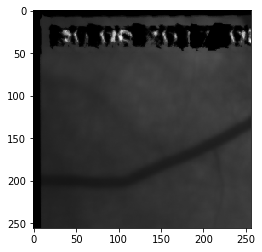

<Figure size 432x288 with 0 Axes>

In [48]:
plt.imshow(patched_img[0])
plt.figure()

In [49]:
preds = model.predict(patched_img)

In [50]:
def compose_img(img_patches, image_dims, cnt_h, cnt_w, mode='mask'):
    if mode == 'mask':
        reconstructed_img = np.zeros((image_dims[0], image_dims[1], 1))
    elif mode == 'image':
        reconstructed_img = np.zeros((image_dims[0], image_dims[1], image_dims[2])) 
    ind_row = 0
    idx = 0
    for row in range(cnt_h): 
        ind_col = 0
        for col in range(cnt_w):
            reconstructed_img[ind_row:ind_row+256, ind_col:ind_col+256, :image_dims[2]] = img_patches[idx]
            ind_col = ind_col + 256
            idx = idx + 1
        ind_row = ind_row + 256
    return reconstructed_img

In [51]:
rec_img = compose_img(patched_img, dims, m_h, m_w, mode='image')

In [52]:
patched_img[0].shape

(256, 256, 3)

In [31]:
preds.shape

(16, 256, 256, 1)

In [53]:
rec_mask = compose_img(preds, dims, m_h, m_w, mode='mask')
rec_img = compose_img(patched_img, dims, m_h, m_w, mode='image')
rec_mask.shape

(1024, 1024, 1)

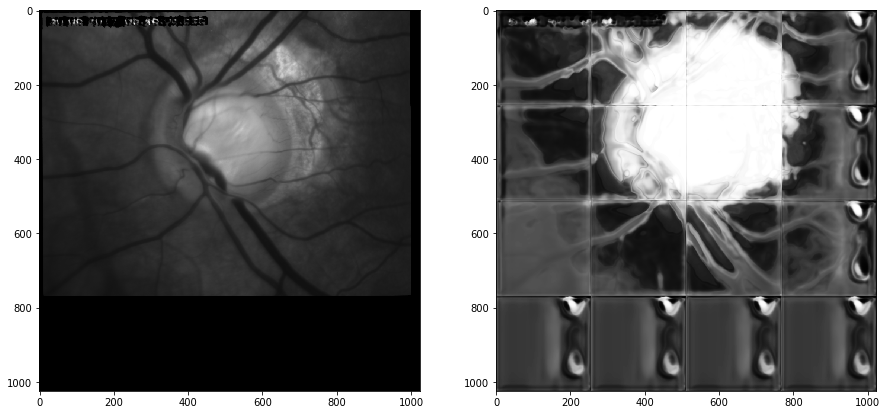

In [56]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(rec_img, cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(rec_mask), cmap='gray')